<a href="https://colab.research.google.com/github/babsyco/Background_infraredLight_filtering/blob/main/NSW_loc_alerts_daily_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tracking NSW Location Alerts for the June 2021 Outbreak

This notebook tallies the number of locations per day for each type of location alert issued by NSW Health. They are tallied by date of exposure event (as opposed to date of public notification). The six alert types are officially labeled:

* Transmission venues of concern
* Close contacts – Get tested immediately and self-isolate for 14 days
* Casual contacts - Get tested immediately and self-isolate until you get a negative result
* Casual contacts – Get tested immediately (people with no symptoms do not need to self-isolate)
* Monitor for symptoms
* Public transport routes

## Method
Individual exposure sites are tallied by event date and alert type using the most recent datasets archived [here](https://github.com/babsyco/C19_NSW_location_alerts), which are sourced from NSW Health [here](https://www.health.nsw.gov.au/Infectious/covid-19/Pages/case-locations-and-alerts.aspx). Within these datasets, exposure events are grouped by venue: events per venue (per dataset) are listed in the "Date and time of exposure" column, and all dates listed in this column follow the format "DD \<month\> YYYY", eg (underlined in green):

<body>
  <br>
  <center>
  <figure>
    <img src="https://drive.google.com/uc?export=download&id=1Ijr5v1pVhcKvCZQjULtBgDH0qdDhNXgk" width="900" align="middle">
    <figcaption>Sample of the 'Close contacts' dataset.</figcaption>
  </figure>
  </center>
<br>
</body>

 This means that by scanning entries in this column for the string "2021", these date strings can be extracted, producing each exposure date per venue. Some data cleaning is also done (see the function `get_date_tallies()` below) to ensure anomalies (double whitespaces, typos etc) are fixed.

### Potential Errors
#### Missed Dates
Event dates may pass undetected if:
* The format '21' is used to represent the year 2021, however this is not seen to be the case anywhere in these datasets. 
* There is a typo in the string '2021', eg '201' (this is an actual typo discovered in one of the datasets). 

However, when '2021' is properly written it will be detected, and these anomalous versions of the string '2021' can be easily searched for using the `get_date_tallies()` function (if the argument `check_year_fmt` is a string it outputs all entries detected that contain that string, for examination).

#### False Positives
Once a date string is extracted, the function `get_date_tallies()` tries to convert the associated string into a datetime value, and if it can not it will thow an error. Several anomalies in the dataset have been detected (and adjusted for) in this way. All dates detected can also easily be output and examined, since the data is currently over a relatively short time period.

In short, where '2021' is correctly written, the event date can not be missed without the user being made aware of it, and it is very unlikely that a typo or text anomaly would still allow a conversion to datetime format and hence a false or incorrect date to be included.

## Troubleshooting
Several code cells contain boolean variables at the top that can be used to configure the cell's output. These can be used to check for anomalies in the data that may need correcting within the `get_date_tallies()` function. This function will also produce an error if a detected string can not be converted to a datetime value. Such text errors will need to be addressed individually within the `text_fixes()` function as they arise.

## Accessing Previous Datasets
Earlier datasets from the [archive repository](https://github.com/babsyco/C19_NSW_location_alerts) can be accessed by setting the `days_back` variable in cell [6] to the desired number of days prior to the most recent dataset available.

In [1]:
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from cycler import cycler
from datetime import date, timedelta, datetime
import matplotlib.dates as mdates
import numpy as np
from pytz import timezone
from google.colab import files
import os

In [2]:
#############
# FUNCTIONS #
#############

# Function for tallying venues per date
def get_date_tallies(df, column, check_year_fmt):
  date_tallies = {}
  date_format = '%d %B %Y'
  
  for val in df[column]:
    # fix text issues
    val = text_fixes(val)
    # check for alternative year format if check_year_fmt is a string
    if isinstance(check_year_fmt, str) and check_year_fmt in val:
      print("\nNote: the string '%s' has been detected in this entry:\n   %s" % (check_year_fmt, val))
    # find word '2021'
    words = list(val.split(' '))
    for i, word in enumerate(words):
      if '2021' in word:
        # get date string 'DD <month> YYYY' and convert to datetime
        date = datetime.strptime(words[i-2] + ' ' + words[i-1] + ' ' + '2021', date_format)
        # add to dict
        if date in date_tallies.keys():
          date_tallies[date] = date_tallies[date] + 1
        else:  
          date_tallies[date] = 1  
  
  return date_tallies

# Insert any pre-processing text fixes needed into here
def text_fixes(val):
  val = val.replace('  ', ' ')
  val = val.replace(u'\xa0', u' ')
  val = val.replace('201', '2021')
  val = val.replace('Jun ', 'June ')
  return val

In [3]:
###################
# IMPORT DATASETS #
###################

# OUTPUT OPTIONS
view_dataset_samples = False

# DATE OFFSET
days_back = 0

# get today's datetime
date_today = datetime.now().astimezone(timezone('Australia/NSW'))
URL_today_dateString = (date_today  - timedelta(days_back)).strftime('%d_%m_%Y')
URL_yesterday_dateString = (date_today  - timedelta(days_back+1)).strftime('%d_%m_%Y')
URL_dateStrings = [URL_today_dateString, URL_yesterday_dateString]

# Note: these URLs require a date string of the format 'DD_MM_YYYY' in the '%s' locations to work
locAlert_dataset_URLs = [
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/CC_VOC_%s.csv',
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/casNeg_VOC_%s.csv',
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/cas_VOC_%s.csv',
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/transmit_VOC_%s.csv',
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/monSympt_VOC_%s.csv',
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/PT_VOC_%s.csv'
              ]

dataset_labels = [
            "Close contact locations ",
            "Casual contacts: isolate and test until negative result ",
            "Casual contacts: test immediately (isolate if symptoms) ",
            "Transmission venues of concern ",
            "Monitor for symptoms ",
            "Public transport routes "
            ]


# import datasets: tries datasets for today's date then increments back until most recent datasets are found
datasets = {}
while(True):
  try:
    for i,label in enumerate(dataset_labels):
      datasets[label + URL_today_dateString] = pd.read_csv(locAlert_dataset_URLs[i] % (URL_today_dateString, URL_today_dateString))
      datasets[label + URL_yesterday_dateString] = pd.read_csv(locAlert_dataset_URLs[i] % (URL_yesterday_dateString, URL_yesterday_dateString))
    break
  except: 
    # converts URL_dateString back to datetime, adds 1 then converts back to string
    URL_today_dateString = (datetime.strptime(URL_today_dateString, '%d_%m_%Y') - timedelta(1)).strftime('%d_%m_%Y')
    continue

# Fix anomalous column name in location alert datasets
for dataset in dataset_labels:
  if 'Date of exposure' in datasets[dataset + URL_today_dateString].columns:
    datasets[dataset + URL_today_dateString].rename(columns={'Date of exposure':'Date and time of exposure'}, inplace=True)
  if 'Date of exposure' in datasets[dataset + URL_yesterday_dateString].columns:
    datasets[dataset + URL_yesterday_dateString].rename(columns={'Date of exposure':'Date and time of exposure'}, inplace=True)
  
# display sample of datasets
if view_dataset_samples:
  print('\nDATASET SAMPLES:')
  for dataset in datasets.keys():
    print('\n\n' + dataset[:-1] + (' (Rows = %d):\n' % datasets[dataset].shape[0]))
    display(datasets[dataset].sample(n=min(5, datasets[dataset].shape[0])))
  
print("%s and %s Datasets imported." % (URL_today_dateString, URL_yesterday_dateString))

05_07_2021 and 04_07_2021 Datasets imported.


In [4]:
################
# EXTRACT DATA #
################

# OUTPUT OPTIONS
view_event_dataset_sizes = False
view_event_dates = False
check_year_fmt = False


####################################
# CHECK THIS NEXT CODE BLOCK
####################################

# Add the 'all dates <dateString>' list and the '<dataset_label> <dateString> (date tallies)' datasets to datasets dict
datasets['all dates'] = []
for label in dataset_labels:
  # today dataset
  datasets[label + URL_today_dateString + " (date tallies)"] = get_date_tallies(datasets[label + URL_today_dateString], 'Date and time of exposure', check_year_fmt)
  for date in datasets[label + URL_today_dateString + " (date tallies)"].keys():
    datasets['all dates'].append(date)
  # yesterday dataset
  datasets[label + URL_yesterday_dateString + " (date tallies)"] = get_date_tallies(datasets[label + URL_yesterday_dateString], 'Date and time of exposure', check_year_fmt)
  for date in datasets[label + URL_yesterday_dateString + " (date tallies)"].keys():
    datasets['all dates'].append(date)

# Add all exposure event dates to all '<dataset_label> (date tallies)' datasets
for date in datasets['all dates']:
  for label in dataset_labels:
    for URL_dateString in [URL_today_dateString, URL_yesterday_dateString]:
      if date not in datasets[label + URL_dateString + " (date tallies)"].keys():
        datasets[label + URL_dateString + " (date tallies)"][date] = 0


# Create dataset of new alert notifications
for label in dataset_labels:
  datasets[label + 'new alerts'] = {}
  for date in datasets['all dates']:
    datasets[label + 'new alerts'][date] = datasets[label + URL_today_dateString + " (date tallies)"][date] - \
                                                  datasets[label + URL_yesterday_dateString + " (date tallies)"][date]

# check '<dataset_label> (date tallies)' dataset sizes
if view_event_dataset_sizes:
  print('NUMBERS OF ROWS IN DATASETS (should be the same):\n')
  for dataset in datasets.keys():
    n_rows = 0
    print("  '%s':\n    %d" % (dataset, len(datasets[dataset])))

# print dates extracted
if view_event_dates:
  print('\nALERT DATES EXTRACTED:\n')
  dates_extracted = sorted(datasets[dataset_labels[0] + URL_today_dateString + " (date tallies)"].keys())
  for i,date in enumerate(dates_extracted):
    print('  %s --- %s' % (date.strftime("%d %B %Y"), f"{i+1:02}"))

print('Exposure event dates extracted.')

Exposure event dates extracted.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

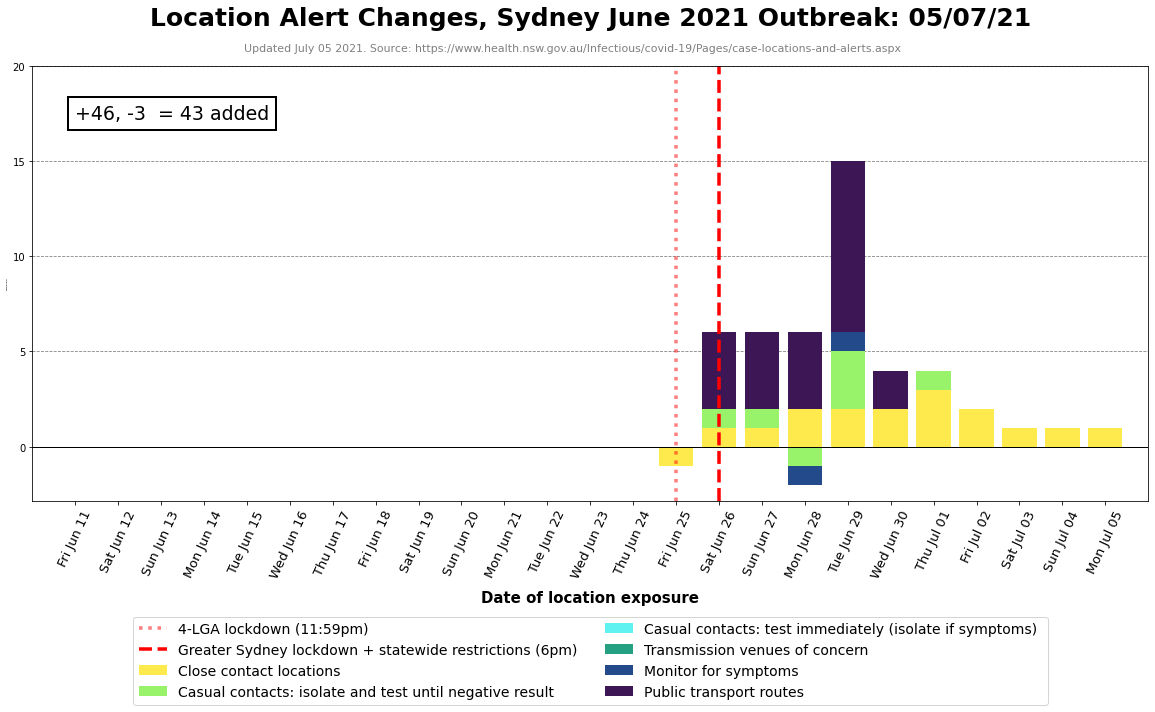

In [14]:
########
# PLOT #
########

# OUTPUT CONTROL
print_data = False

# matplotlib settings
plt.rcParams.update({'font.family':'Arial'})
custom_cycler = (cycler(color=['yellow','orange','crimson', 'mediumorchid', 'blue', 'black']))

# colors
# get colors as hex: https://www.tldevtech.com/hex-color-picker/
#colors = list(cm.plasma(np.linspace(1, 0, 5)))
colors = ['#FFEA4E','#99F36A', '#26A083', '#234B8C', '#3C1655']
colors.insert(2, '#60F2F1')
alpha = 1

# plot data
x_data = sorted(list(datasets[dataset_labels[0] + "new alerts"].keys()))
x_ticks = [min(x_data) + timedelta(i) for i in range((date_today.replace(tzinfo=None) - min(x_data)).days + 1)]
LGA4_lockdown = datetime(2021, 6, 25).astimezone(timezone('Australia/NSW'))
greaterSydney_lockdown = datetime(2021, 6, 26).astimezone(timezone('Australia/NSW'))
subtitle_string = ("Updated %s." % date_today.strftime('%B %d %Y')) +\
                    " Source: https://www.health.nsw.gov.au/Infectious/covid-19/Pages/case-locations-and-alerts.aspx"

# remove zero values

# create plot
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
prev_pos_data = []
prev_neg_data = []
# plot location alert data
for i,label in enumerate(dataset_labels):
  y_data = [datasets[label + "new alerts"][x] for x in x_data]
  if print_data:
    print(label)
    for k in range(len(x_data)):
      print("%s ---- %d" % (str(x_data[k]), y_data[k]))
  if i == 0:
    ax.bar(x_data, y_data, label=label, color=colors[i], alpha=alpha) #, color=colors[i]
    prev_pos_data = [max(y, 0) for y in y_data]
    prev_neg_data = [min(y, 0) for y in y_data]
  else:
    curr_prev_pos_data = [p if y >= 0 else n for y,p,n in zip(y_data, prev_pos_data, prev_neg_data)]
    ax.bar(x_data, y_data, bottom=curr_prev_pos_data, label=label, alpha=alpha, color=colors[i]) # , color=colors[i] 
    prev_pos_data = np.array([max(y, 0) for y in y_data]) + np.array(prev_pos_data)
    prev_neg_data = np.array([min(y, 0) for y in y_data]) + np.array(prev_neg_data)
# y-axis formatting
ax.set_ylim(ax.get_ylim()[0], max(ax.get_ylim()[1], 20))
# plot lockdown lines
ax.plot([LGA4_lockdown]*2, ax.get_ylim(), color='red', linestyle=':', linewidth=3.5, label='4-LGA lockdown (11:59pm)', alpha=alpha/2)
ax.plot([greaterSydney_lockdown]*2, ax.get_ylim(), color='red', linestyle='--', linewidth=3.5, 
        alpha=alpha, label='Greater Sydney lockdown + statewide restrictions (6pm)')
# add text: totals
props = dict(facecolor='white', pad=7, linewidth=2)
if sum(prev_neg_data + prev_pos_data) >= 0:
  total_string = '%s added' % sum(prev_neg_data + prev_pos_data)
else:
  total_string = '%s removed' % sum(prev_neg_data + prev_pos_data)
ax.text(x_data[int(len(x_data)*0.0)], sum(ax.get_yticks()[-2:])/2, '+%d, %d  = %s' % (sum(prev_pos_data), sum(prev_neg_data), total_string), 
        bbox=props, ha='left', va='center', fontsize=19)
# x-axis formatting
ax.set_xticks(x_ticks)
ax.set_xlim(min(x_ticks)-timedelta(1), max(x_ticks)+timedelta(1))
ax.set_xticklabels(x_ticks, rotation=65, fontsize=13)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %b %d'))
ax.plot(list(ax.get_xlim()), [0]*2, color='black', linewidth=1)
# plot formatting
ax.set_title("Location Alert Changes, Sydney June 2021 Outbreak: %s" % date_today.strftime("%d/%m/%y"), fontsize=25, y=1.08, fontweight='bold')
plt.suptitle(subtitle_string, fontsize=11, y=0.92, color='gray')
ax.legend(loc='upper center', fontsize=14, ncol=2, bbox_to_anchor=(0.5, -0.25))
ax.set_xlabel("Date of location exposure", fontsize=15, fontweight='bold', labelpad=10)
ax.set_ylabel("Number of locations", fontsize=1, fontweight='bold')

# set to True to print a single date's data to visually confirm plot
if False:
  test_date = datetime.strptime('26 June 2021', '%d %B %Y')
  for label in dataset_labels:
    print('%s: %d' % (label[:-1], datasets[label + " (date tallies)"][test_date]))

# set to True to save .png of plot
if True:
  if not os.path.exists('plots'):
    os.makedirs('plots')
  filename = 'SydJun2021_locAlerts_change_' + URL_dateString
  plt.savefig(filename, bbox_inches = 'tight')
  files.download(filename+'.png')